Convert to reveal.js presentation with: ``jupyter-nbconvert talk.ipynb --to slides``

To run this notebook you need Python 3.4+ and recent versions of:
* jupyter
* numpy
* h5py
* pandas
* scikit-learn (for k-dimensional search trees)
* scipy

The quickest way to install these packages is by installing the [Anaconda](https://www.continuum.io/downloads) distribution.

In [1]:
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

# creates "realistic" random 2d arrays
from random_arr import random_array

In [2]:
# Helper function

def regular_grid(shape, xmin, xmax, ymin, ymax):
    """
    Create regular 2d x/y grid

    Args:
        shape: tuple (lines, columns)
        xmin: minimum x coordinate (e.g. longitude)
        xmax: maximum x coordinate
        ymin: minimum y coordinate (e.g. latitude)
        ymax: maximum y coordinate

    Returns:
        tuple (x, y)
    """
    y_range = np.linspace(ymax, ymin, shape[0])
    x_range = np.linspace(xmin, xmax, shape[1])
    x, y = np.meshgrid(x_range, y_range)

    return x, y

# storing & querying spatiotemporal raster data with hdf5

### Remo Goetschi, Meteotest

<img src="weather.png">

# Geospatial raster data sources

* rain radar
* numerical weather prediction
* climate models
* air pollution
* remote sensing (satellites, ...)
* ...

<img src="weather.png" width="50%">

# How to store all that data?

Sql DBs (e.g., PostGIS) are not a good choice. There are array databases, but...

[PostGIS Raster](https://trac.osgeo.org/postgis/wiki/WKTRaster): data I/O is cumbersome, no NumPy API, documentation outdated.

[Rasdaman](http://www.rasdaman.com/): implements OGC standards, lack of documentation, no Python client, felt slow.

[SciDB](http://www.paradigm4.com/): great, but focus is data analysis, not fast queries.

Oracle, Esri: closed source

# What is hdf5?
**short answer**: a binary file format for storing large numerical arrays (think "NumPy arrays").

**h** stands for _hierarchical_ $\Rightarrow$ arrays can be stored in groups.

C-library developed by
<img src="hdf_logo.jpg"/>

Used by NASA and many others for data exchange and storage.

Python has two great hdf5 libs: [h5py](http://www.h5py.org/) and [PyTables](http://www.pytables.org/).

## hdf5 example

In [3]:
import h5py

temp_2m = random_array((200, 400), minvalue=-20, maxvalue=30)

with h5py.File("weather.h5", "w") as f:
    f["/temperature/2m"] = temp_2m
    f["/temperature/2m"].attrs["unit"] = "celsius"
    f["/temperature/2m"].attrs["desc"] = "temperature 2m above ground"

<img src="hdfview.png"/>

Groups act like dictionaries<br/>
(note that the file itself is also a group):

In [4]:
f = h5py.File("weather.h5")
grp = f["/temperature"]
dataset = grp["2m"]
print(grp)
print(dataset)

<HDF5 group "/temperature" (1 members)>
<HDF5 dataset "2m": shape (200, 400), type "<f8">


Datasets are like NumPy arrays "on disk":

In [5]:
dataset.shape

(200, 400)

In [6]:
dataset[:] += 10
dataset[50, 78]

29.166526948671873

Slicing allows to read fragments of a dataset into memory:

In [7]:
data = dataset[50:150, 200:400]

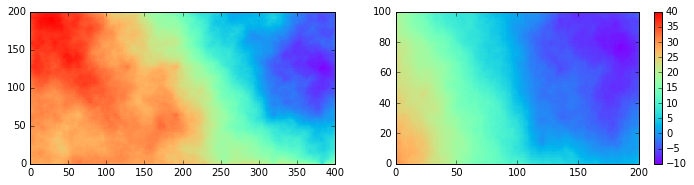

In [8]:
plt.figure(1, figsize=(12, 6))
plt.subplot(221)
plt.pcolormesh(dataset[:], vmin=-10, vmax=40, cmap="rainbow")
plt.subplot(222)
plt.pcolormesh(data, vmin=-10, vmax=40, cmap="rainbow")
plt.colorbar()

In [9]:
f.close()

# Advanced hdf5 features

* Compression & chunking (affects performance!)
* Soft and hard links (``f['/mygrp/link'] = dset``)
* Links to other files
* "Pointers" to "regions of interest" in a dataset
* It's fast!

# Performance comes at a price...

* No "out-of-core" computation built-in
* No transactional database features
* Concurrency is non-trivial...

Remark: For "out-of-core" computations, check the [Blaze ecosystem](http://blaze.pydata.org/).

# What about georeferencing??

Hdf5 is an **abstract** format (like xml) that does not provide any semantics for spatial or temporal data.

We <span style="text-decoration: line-through;">have to</span> are free to define our own format...

Remark: Netcdf4 is such a format. But let's create our own format...

# Storing spatiotemporal data

**Goal**: Create an hdf5-format and a simple API that work like this...

In [10]:
from h5geodb import GeoDB  # cf. h5geodb.py

In [11]:
lons, lats = regular_grid((400, 500), xmin=0, xmax=20, ymin=40, ymax=60)

db = GeoDB.create("wind.h5", frequency=60, lat=lats, lon=lons)

In [12]:
wind = random_array(lats.shape, minvalue=0, maxvalue=30)
t = datetime(2016, 6, 23, 9, 0)

In [13]:
db.store(param="wind/2m", data=wind, time=t)

In [14]:
db.store(param="wind/2m", data=wind * 0.8,
         time=t + timedelta(hours=1))
db.store(param="wind/2m", data=wind * 0.6,
         time=t + timedelta(hours=2))

# File format behind such an API

* All time steps of a single day are stored in one dataset ``YYYYMMDD``
* Time stored in a 3rd dimension
* A bit-array (``00011100...``) identifies uninitialized time steps

<img src="geodb.png"/>

# Querying array data

In [15]:
lat, lon, data = db.data("wind/2m", t,
                         minlat=42, maxlat=55,  #optional
                         minlon=4, maxlon=15)

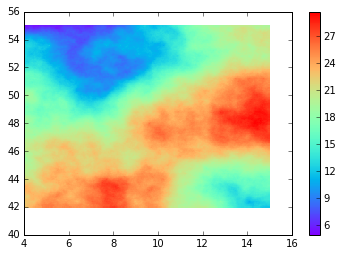

In [16]:
plt.pcolormesh(lon, lat, data, cmap="rainbow")
plt.colorbar()

## Querying point data

<img src="windquery.png"/>

In [17]:
lat0, lon0 = 47.2, 5.2
lat, lon, data = db.point_data("wind/2m", lat0, lon0,
                               start=t, end=t + timedelta(hours=2))
print(data)

2016-06-23 09:00:00    20.211024
2016-06-23 10:00:00    16.168819
2016-06-23 11:00:00    12.126614
Freq: 60T, dtype: float64


In [18]:
print("nearest point: {}, {}".format(lat, lon))

nearest point: 47.21804511278196, 5.210420841683367


# Nearest neighbor search

Use a **k-dimensional search tree**.

Convert lat/lon points to 3d coordinates in unit sphere.

Once tree is constructed, we can find nearest neighbor(s) – w.r.t. "tunnel distance" – in $\mathcal{O}(log\ n)$.

<img src="tunnel_distance.png"/>

# Concurrency

If files are **"write once, read many"**: no problem.

Don't use threads, though!<br/>
Calls to Hdf5 are **blocking**, i.e., GIL is not released while waiting on I/O events.<br/>
(it's thread-safe, but not thread-efficient)

If you need **parallel read/write**, there are options:

* [Parallel hdf5](http://docs.h5py.org/en/latest/mpi.html): uses MPI, useful for parallel computing, not for "backends"
* [h5serve](https://github.com/HDFGroup/h5serv) REST server: single-threaded, serializes file access
* [h5pySWMR](https://github.com/meteotest/h5pySWMR): drop-in replacement for h5py with efficient "single writer multiple readers" synchronization

Seperate hdf5 data access from your web application!

Slides and Jupyter notebook: https://github.com/weatherfrog/geopython2016


Further reading:
<img src="book_cover.png"/>

**Swiss summer** (map tiles served & rendered with Python3 / matplotlib):
<video id="videoRadar" src="./radar.mp4" type="video/mp4" width="320" height="240" controls loop>
</video>

# Chunking and Compression
By default, hdf5 stores data contiguously.

Optionally, hdf5 can store datasets in chunks, i.e. same-sized pieces that are stored anywhere on disk.
Chunked datasets allow for resizing and compression...

In [21]:
f = h5py.File("weather.h5", "a")
dst = f.create_dataset("foo", shape=((1000, 2000)), dtype=np.int32,
                       chunks=(60, 100), compression='gzip')
dst[543] = np.arange(2000)  # array is compressed

Data is stored in chunks/blocks of

$$60 \times 100 \times 32 bit = 24 kB$$

Chunking and compression greatly affect performance!<br/>
(positively or negatively)

In [22]:
dst[543, 20:22]  # reads whole chunk(s)!

array([20, 21], dtype=int32)

In [23]:
f.close()